In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from matplotlib import pyplot as plt
from os import path
from quenching import calc_quenched_flour, fit_quenching_linear_unitless, mark_non_quenchers
from quenching import well_mean_with_error_propagation

In [2]:
# Load data from in-vitro RTDP plate reader experiments. 
long_df_pre = pd.read_csv('../data/O2NS_isolate_supes/O2NS_long_df_pre.csv', index_col=0)
long_df_post = pd.read_csv('../data/O2NS_isolate_supes/O2NS_long_df_post.csv', index_col=0)
# Manually mixed prior to measurement here, so we will keep all the data.

# Infer the quenched fluorescence by comparing pre/post measurements
long_df_pre, long_df_post, blank_vals, pt_alone_fluors = calc_quenched_flour(
    long_df_pre, long_df_post, "pt_fluor", "O2NS")

# In this case data comes from a single date, so there is only one blank (mean+/-std) and reference value.
blank_val = blank_vals.iloc[0]
pt_alone_fluor = pt_alone_fluors.iloc[0]

long_df_pre.to_csv("../data/O2NS_isolate_supes/O2NS_long_df_pre_processed.csv")
long_df_post.to_csv("../data/O2NS_isolate_supes/O2NS_long_df_post_processed.csv")

print("blank", blank_val)
print("O2NS (PtTFPP) in buffer", pt_alone_fluor)
cv = pt_alone_fluor.std_dev/pt_alone_fluor.nominal_value
print("CV of O2NS (PtTFPP) in buffer {0:.2f}%".format(100*cv))

blank 82+/-26
O2NS (PtTFPP) in buffer (6.17+/-0.35)e+03
CV of O2NS (PtTFPP) in buffer 5.69%


In [3]:
# Peek at the data
mask = long_df_post.name == 'PA14 WT'
long_df_post[mask].head()

,time_s,well,pt_fluor,concentration,fold_dilution,media,name,replicate,plate,date,blanked_pt_fluor,expected_blanked_pt_fluor,estimated_true_pt_fluor,F0_F_ratio,F_F0_ratio,u_blanked_pt_fluor,u_expected_blanked_pt_fluor,u_estimated_true_pt_fluor,u_F0_F_ratio,u_F_F0_ratio
0,0.000,A1,7990,0.900901,1,MM gluc+AA,PA14 WT,1,1,5/27/22,7908.09375,9811.947917,4267.468750,1.446132,0.691500,26.15943,351.907491,2.592376,0.082282,0.039345
1,140.038,A1,7969,0.900901,1,MM gluc+AA,PA14 WT,1,1,5/27/22,7887.09375,9831.767736,4226.648930,1.460098,0.684885,26.15943,351.907491,2.592376,0.083077,0.038969
2,280.083,A1,7822,0.900901,1,MM gluc+AA,PA14 WT,1,1,5/27/22,7740.09375,9852.488457,4058.928209,1.520432,0.657708,26.15943,351.907491,2.592376,0.086510,0.037423
3,420.113,A1,7726,0.900901,1,MM gluc+AA,PA14 WT,1,1,5/27/22,7644.09375,9853.389358,3962.027309,1.557617,0.642006,26.15943,351.907491,2.592376,0.088627,0.036529
4,0.000,A2,6096,0.450450,2,MM gluc+AA,PA14 WT,1,1,5/27/22,6014.09375,7782.218187,4403.198480,1.401555,0.713493,26.15943,351.907491,2.592376,0.079746,0.040596


In [4]:
means_pre_by_rep = well_mean_with_error_propagation(long_df_pre, "pt_fluor", pt_alone_fluor)
means_post_by_rep = well_mean_with_error_propagation(long_df_post, "pt_fluor", pt_alone_fluor)
means_pre_by_rep.to_csv("../data/O2NS_isolate_supes/mean_O2NS_fluor_pre.csv")
means_post_by_rep.to_csv("../data/O2NS_isolate_supes/mean_O2NS_fluor_post.csv")

In [5]:
# calculate the KSV values for RTDP + various molecules by fitting to the linear form of 
# the Stern-Volmer model of equilibrium quenching. We fit the averaged data so that each 
# well is counted only once during the fitting. 

# Molecules are called non-quenchers if quenching is only weakly correlated with their
# concentrations or, alternatively, if the degree of quenching is low enought to be 
# consistent with no quenching at all, i.e. if it cannot be distinguished from the 
# variance of the signal of sensor (O2NS here) in buffer.
name_order = sorted(
    set(long_df_post.name.unique()).difference('BLANK,O2NS'.split(',')))
print(name_order)
fitting_df = means_post_by_rep.reset_index()
quencher_fit_df = fit_quenching_linear_unitless(fitting_df, name_order)

print("Minimum effect size (CV of O2NS): {0:.2g}".format(cv))
quencher_fit_df = mark_non_quenchers(quencher_fit_df, min_effect_size=cv)

# Save the fits
quencher_fit_df.to_csv("../data/O2NS_isolate_supes/fits.csv")
quencher_fit_df

['AGG', 'BG', 'CG', 'CS', 'EC WT', 'MM4', 'PA14 WT', 'PO', 'PS']
Fitting AGG
	F0/F ~ [AGG] with R = 0.605
Fitting BG
	F0/F ~ [BG] with R = 0.004
Fitting CG
	F0/F ~ [CG] with R = 0.414
Fitting CS
	F0/F ~ [CS] with R = 0.175
Fitting EC WT
	F0/F ~ [EC WT] with R = 0.075
Fitting MM4
	F0/F ~ [MM4] with R = -0.168
Fitting PA14 WT
	F0/F ~ [PA14 WT] with R = 0.814
Fitting PO
	F0/F ~ [PO] with R = 0.904
Fitting PS
	F0/F ~ [PS] with R = 0.846
Minimum effect size (CV of O2NS): 0.057


,name,K_SV,K_SV err,R,quencher
0,AGG,0.430884,0.075596,0.604797,True
1,BG,0.255456,0.068047,0.004407,False
2,CG,0.230028,0.063517,0.413695,True
3,CS,0.390645,0.070330,0.175087,False
4,EC WT,-0.049185,0.056123,0.075255,False
5,MM4,-0.027015,0.053365,-0.168204,False
6,PA14 WT,0.535242,0.089115,0.814426,True
7,PO,0.348957,0.074228,0.904007,True
8,PS,0.362694,0.069370,0.845687,True


All is now preprocessed, fit and exported. 
Everything below here is just exploring the data.

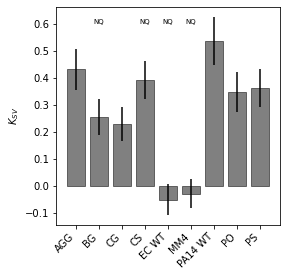

In [6]:
# Index fits by name for easier lookup
o2ns_fits = quencher_fit_df.set_index('name')

# Some of the better quenchers, e.g. toxoflavin, give a non-linear response curve as expected from theory. 
# However, the non-linear model has an additional degree of freedom, it gives much larger errors on the KSV value.
# As such it makes more sense to report value +/- error for the linear model and discuss the non-linearity in the SI.
xs = np.arange(o2ns_fits.index.size)
ys = o2ns_fits['K_SV']
yerr = o2ns_fits['K_SV err']

plt.figure(figsize=(4,4))
plt.bar(xs, ys, yerr=yerr, color='grey', edgecolor='k', lw=0.5, ecolor='k')

for i, (idx, row) in enumerate(o2ns_fits.iterrows()):
    if not row.quencher:
        plt.text(i, 0.6, 'NQ', ha='center', fontsize=7)
        
plt.ylabel('$K_{SV}$')
plt.xticks(xs, o2ns_fits.index, rotation=45, ha='right')
plt.show()

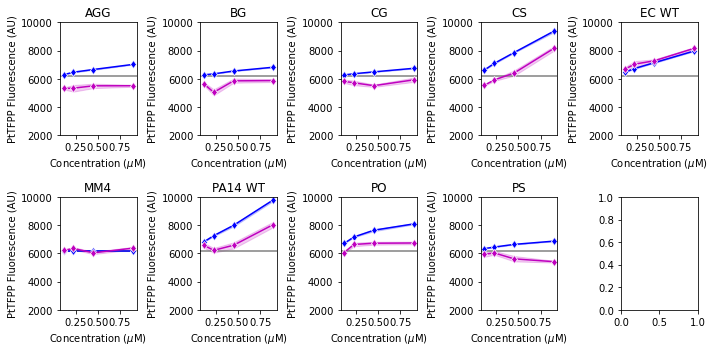

In [7]:
fig, axs = plt.subplots(figsize=(10,5), ncols=5, nrows=2)
flat_axs = axs.flatten()
name_order = o2ns_fits.index.values 

for qname, my_ax in zip(name_order, flat_axs):
    plt.sca(my_ax)
    
    qdf_pre = long_df_pre[long_df_pre.name == qname]
    qdf_post = long_df_post[long_df_post.name == qname]
    
    plt.axhline(pt_alone_fluor.nominal_value, color='grey')
    sns.lineplot(data=qdf_post, x='concentration', y='expected_blanked_pt_fluor', 
                 color='b', marker='d', markersize=6)
    
    sns.lineplot(data=qdf_post, x='concentration', y='blanked_pt_fluor', 
                 color='m', marker='d', markersize=6)
    
    plt.title(qname)
    plt.ylim(2000, 10000)
    plt.xlabel('Concentration ($\mu$M)')
    plt.ylabel('PtTFPP Fluorescence (AU)')
    
plt.tight_layout()
plt.savefig('../figures/o2ns_vitro.png', facecolor='w', dpi=600)
plt.show()

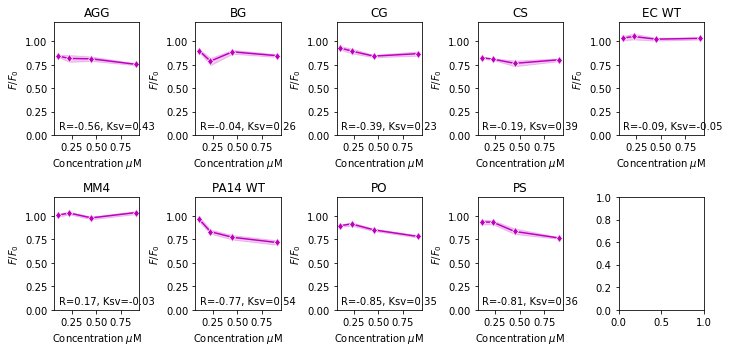

In [8]:
fig, axs = plt.subplots(figsize=(10,5), ncols=5, nrows=2)
flat_axs = axs.flatten()

for qname, my_ax in zip(name_order, flat_axs):
    plt.sca(my_ax)
    
    qdf_pre = long_df_pre[long_df_pre.name == qname]
    qdf_post = long_df_post[long_df_post.name == qname]
        
    sns.lineplot(data=qdf_post, x='concentration', y='F_F0_ratio', 
                 color='m', marker='d', markersize=6)
    
    corr = qdf_post.corr().loc['concentration', 'F_F0_ratio']
    slope = o2ns_fits.loc[qname]['K_SV']
    plt.text(0.05, 0.05, 'R={0:.2f}, Ksv={1:0.2f}'.format(corr, slope),
             transform=my_ax.transAxes)
    
    plt.title(qname)
    plt.ylim(0, 1.2)
    plt.xlabel('Concentration $\mu$M')
    plt.ylabel('$F / F_0$')
    
plt.tight_layout()